# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    """Print user defined number of training example-label pairs."""
    
    for i in range(num_examples):
        print("Training Example:\n",train_data[i],"\n")
        print("Training Label:\n", train_labels[i])
        print()

P1(5)

Training Example:
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

Training Label:
 1

Training Example:
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 


### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2(docs=train_data):
    """Transform documents into n-gram feature vectors and compare size, non-zero feature
    fractions, and feature string bookend values (First and Last feature strings)."""
    
    #Word Unigram, Full Vocabulary
    print("Word Unigram, Full Vocabulary")
    count = CountVectorizer(ngram_range=(1,1))
    bag = count.fit_transform(docs)
    cols = count.get_feature_names()
    print("Vocabulary Size:",bag.shape[1])
    print("Average Non-Zero Features Per Example:",np.mean(bag.sum(1)))
    print("Non-Zero Value Proportion in Matrix:",bag.nnz/(bag.shape[0]*bag.shape[1]))
    print("First and Last Feature Strings:",cols[0], cols[bag.shape[1]-1])
    print()
    
    #Word Unigram, Small Vocabulary
    print("Word Unigram, Small Vocabulary")
    count = CountVectorizer(ngram_range=(1,1), vocabulary=["atheism", "graphics", "space", "religion"])
    bag = count.fit_transform(docs)
    print("Vocabulary Size:",bag.shape[1])
    print("Average Non-Zero Features Per Example:",np.mean(bag.sum(1)))
    print()
    
    #Character Bigram and Trigram, Full Vocabulary
    print("Character Bigram and Trigram, Full Vocabulary")
    count = CountVectorizer(ngram_range=(2,3), analyzer='char')
    bag = count.fit_transform(docs)
    print("Vocabulary Size:",bag.shape[1])
    print()
    
    #Word Unigram, Prune Rare Words
    print("Word Unigram, Prune Rare Words")
    count = CountVectorizer(ngram_range=(1,1),min_df=10/len(docs))
    bag = count.fit_transform(docs)
    print("Vocabulary Size:",bag.shape[1])
    print()
    
    #Compare Training and Dev Vocabularies
    print("Word Unigram, Find gaps between training and dev data")
    train_count = CountVectorizer(ngram_range=(1,1))
    train_bag = train_count.fit_transform(docs)
    train_cols = train_count.get_feature_names()
    
    dev_count = CountVectorizer(ngram_range=(1,1))
    dev_bag = dev_count.fit_transform(dev_data)
    dev_cols = dev_count.get_feature_names()
    
    #Identify number of unique words in dev that are not in train
    dev_gap = 0
    for i in train_cols:
        if i not in dev_cols:
            dev_gap+=1
    
    #Calculate proportion of dev values that are unique
    missing = dev_gap/len(train_cols)
    print("Proportion of Unique Values in Dev:", missing)
    

P2()

Word Unigram, Full Vocabulary
Vocabulary Size: 26879
Average Non-Zero Features Per Example: 185.43362831858408
Non-Zero Value Proportion in Matrix: 0.0035978272269590263
First and Last Feature Strings: 00 zyxel

Word Unigram, Small Vocabulary
Vocabulary Size: 4
Average Non-Zero Features Per Example: 0.9410029498525073

Character Bigram and Trigram, Full Vocabulary
Vocabulary Size: 35478

Word Unigram, Prune Rare Words
Vocabulary Size: 3064

Word Unigram, Find gaps between training and dev data
Proportion of Unique Values in Dev: 0.5454071952081551


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
import warnings
warnings.filterwarnings('ignore')

def P3():
    """Produce a number of KNN, Naive Bayes, and Logistic Regression models on word unigram feature vectors"""
    
    #Transform training and dev data into word unigram feature vectors
    count = CountVectorizer(ngram_range=(1,1))
    train_bag = count.fit_transform(train_data)
    dev_bag = count.transform(dev_data)
    
    
    
    #Produce several k-Nearest Neigbors models by varying k, including one with k set to 
    #optimize f1 score. For each model, show the k value and f1 score.
    print("Generate KNN Models with varying K Values:")
    for k in [1,2,3,4,5,6,7]:
        knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
        knn.fit(train_bag,train_labels)
        pred = knn.predict(dev_bag)
        print("KNN Model with k=",k,"has an f1 value of",metrics.f1_score(dev_labels,pred,average='weighted'))
        
    #Produce several Naive Bayes models by varying smoothing (alpha), including 
    #one with alpha set approximately to optimize f1 score.  For each model, show 
    #the alpha value and f1 score.
    print("\nGenerate MultinomialNB Models with varying alpha values:")
    for alpha in [.001,.01,.1,.25,.5,.75,.9,.99,.999,1]:
        mnb = MultinomialNB(alpha=alpha)
        mnb.fit(train_bag,train_labels)
        pred = mnb.predict(dev_bag)
        print("Multinomial Naive Bayes Model with alpha=",alpha,
              "has an f1 value of",metrics.f1_score(dev_labels,pred,average='weighted'))
    
    #Produce several Logistic Regression models by varying L2 regularization strength (C), 
    #including one with C set approximately to optimize f1 score. For each model, 
    #show the C value, f1 score, and sum of squared weights for each topic.
    print("\nGenerate Logistic Regression Models with varying L2 values:")
    for c in [.001,.01,.1,1,10,100,1000]:
        lr = LogisticRegression(C=c)
        lr.fit(train_bag,train_labels)
        pred = lr.predict(dev_bag)
        sqweights = np.square(lr.coef_)
        sumsquare = np.sum(sqweights, axis=1)
        print("Logistic Regression Model with L2 =",c,
              "has an f1 value of",metrics.f1_score(dev_labels,pred,average='weighted'))
        print("Sum of Squared Weights:")
        print(sumsquare)
        
    

P3()

Generate KNN Models with varying K Values:
KNN Model with k= 1 has an f1 value of 0.3805030018531525
KNN Model with k= 2 has an f1 value of 0.38054212404441684
KNN Model with k= 3 has an f1 value of 0.4084150225437623
KNN Model with k= 4 has an f1 value of 0.4031227993847515
KNN Model with k= 5 has an f1 value of 0.4287607236218357
KNN Model with k= 6 has an f1 value of 0.4466650540867595
KNN Model with k= 7 has an f1 value of 0.45047910006117586

Generate MultinomialNB Models with varying alpha values:
Multinomial Naive Bayes Model with alpha= 0.001 has an f1 value of 0.7702518836155706
Multinomial Naive Bayes Model with alpha= 0.01 has an f1 value of 0.7751663218544357
Multinomial Naive Bayes Model with alpha= 0.1 has an f1 value of 0.7903052385098862
Multinomial Naive Bayes Model with alpha= 0.25 has an f1 value of 0.7890335791591067
Multinomial Naive Bayes Model with alpha= 0.5 has an f1 value of 0.7862862961995258
Multinomial Naive Bayes Model with alpha= 0.75 has an f1 value of 0

ANSWER:  
K-Nearest Neighbors doesn't work well for this problem because of the sparsity of the data. A given test example may have very few close-proximity neighbors in the training set and these neighbors may be close virtue of the fact that they share words that are common between all categories of documents.  

Logistic regression likewise suffers from the sparseness of the data as this makes it difficult for the algorithm to identify the most significant parameter values. By contrast, Naive Bayes can easily identify meaningful features - such as unique words that only identify in a certain class - as significant while weighting down words that are equally frequent or infrequent among all categories.  

As the C value in the logistic regression models increases, so do the sums of the squared weights.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [6]:
def P4():
    """Produce a model based on word bigram features and identify the 5 highest 
    weighted features for each category"""
    
    #Create a word bag from the training data set
    count = CountVectorizer(ngram_range=(2,2))
    train_bag = count.fit_transform(train_data)
    
    #Fit the data to a logistic regression model
    lr = LogisticRegression()
    lr.fit(train_bag,train_labels)
    
    #extract weights and feature names
    weights = lr.coef_
    cols = count.get_feature_names()
    
    #Create the weight table
    headers = ['Bigram','Atheism', 'Comp Graphics', 'Sci & Space', 'Religion']
    print(*headers)
    for i in range(weights.shape[0]):
        sc = np.argsort(weights[i])
        top5 = sc[len(sc)-5:len(sc)]
        tab = []
        for j in top5:
            print(cols[j], end=' ')
            for k in range(weights.shape[0]):
                print("%.2f" % weights[k,j], end=' ')
            print()
P4()

Bigram Atheism Comp Graphics Sci & Space Religion
you are 0.47 -0.18 -0.38 0.09 
look up 0.50 -0.19 -0.17 -0.15 
was just 0.52 -0.15 -0.15 -0.22 
cheers kent 0.54 -0.55 -0.50 0.52 
claim that 0.54 -0.18 -0.23 -0.13 
out there -0.16 0.64 -0.31 -0.17 
is there -0.23 0.70 -0.29 -0.18 
in advance -0.27 0.73 -0.21 -0.25 
comp graphics -0.24 0.77 -0.28 -0.25 
looking for -0.41 1.01 -0.21 -0.38 
sci space -0.17 -0.19 0.52 -0.15 
how ironic -0.17 -0.22 0.56 -0.17 
sherzer methodology -0.17 -0.23 0.58 -0.18 
the moon -0.22 -0.31 0.63 -0.10 
the space -0.17 -0.35 0.69 -0.17 
cheers kent 0.54 -0.55 -0.50 0.52 
is strength -0.15 -0.19 -0.17 0.52 
ignorance is -0.18 -0.21 -0.19 0.58 
compuserve com -0.16 -0.23 -0.22 0.60 
such lunacy -0.17 -0.23 -0.21 0.61 


ANSWER:  

There are features in this table that are not surprising, such as the fact that "comp graphics" and "sci space" are heavily weighted for the Comp Graphics and Sci & Space categories, respectively. We also see the "Cheers Kent" feature as a strong determinent is both the Atheism and Religion categories, which appears to categorize documents based on the posts by a single high-frequency contributer. This is not particularly surprising that this would come up, but it may not help performance depending on the test set.  

The surprising features are ones that seem to identify common speech patterns among the various online communities. For example "look up" and "claim that" in the atheist community or "such lunacy" and "ignorance is" and "is strength" in the religious community.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
import copy

def better_preprocessor(s):
    
    # Convert text to lowercase
    s = s.lower()
    
    # Remove underscores
    s = re.sub(r"_", r"", s)
    
    # removing suffixes
    s = re.sub(r"ed", r"", s)
    s = re.sub(r"s", r"", s)
    s = re.sub(r"y", r"", s)
    s = re.sub(r"ing", r"", s)
    
            
    return s
    
def P5():
    """Compare results of non processed and preprocessed data 
    applied to a logistic regression model"""
    
    #Count Vectorizor with no preprocessor
    count = CountVectorizer()
    train_bag = count.fit_transform(train_data)
    dev_bag = count.transform(dev_data)
    
    #Logistic Regression model applied to unprocessed data
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(train_bag,train_labels)
    pred = lr.predict(dev_bag)
    print("Logistic Regression model with no preprocessing has an f1 value of",
          metrics.f1_score(dev_labels,pred,average='weighted'))
    
    #Count Vectorizer with better_preprocessor
    count_trans = CountVectorizer(preprocessor=better_preprocessor)
    train_bag_trans = count_trans.fit_transform(train_data)
    dev_bag_trans = count_trans.transform(dev_data)
    
    #Logistic Regression model applied to preprocessed data
    lr_trans = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr_trans.fit(train_bag_trans,train_labels)
    pred2 = lr_trans.predict(dev_bag_trans)
    print("Logistic Regression model with preprocessing has an f1 value of",
          metrics.f1_score(dev_labels,pred2,average='weighted'))
    
    #Show vocabulary reduction
    print()
    print("Vocabulary reduced from",train_bag.shape[1],"to",train_bag_trans.shape[1])

P5()

Logistic Regression model with no preprocessing has an f1 value of 0.7084739776490449
Logistic Regression model with preprocessing has an f1 value of 0.718025489350521

Vocabulary reduced from 26879 to 21013


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

The Logistic Regression model with L1= 0.001 yields a new vocabulary size of 3 and an f1= 0.31237953241774374
The Logistic Regression model with L1= 0.01 yields a new vocabulary size of 18 and an f1= 0.46210921676182215
The Logistic Regression model with L1= 0.1 yields a new vocabulary size of 211 and an f1= 0.6670318594752909
The Logistic Regression model with L1= 0.2 yields a new vocabulary size of 366 and an f1= 0.6639069246789056
The Logistic Regression model with L1= 0.3 yields a new vocabulary size of 549 and an f1= 0.6518062135534548
The Logistic Regression model with L1= 0.5 yields a new vocabulary size of 743 and an f1= 0.6377248537808503
The Logistic Regression model with L1= 1 yields a new vocabulary size of 1066 and an f1= 0.6602060297304828
The Logistic Regression model with L1= 2 yields a new vocabulary size of 1726 and an f1= 0.6642511672541885
The Logistic Regression model with L1= 3 yields a new vocabulary size of 2533 and an f1= 0.6692601262552735
The Logistic Regress

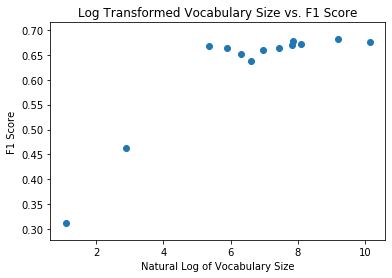

In [8]:
def P6():
    """"""
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    count = CountVectorizer()
    train_bag = count.fit_transform(train_data)
    dev_bag = count.transform(dev_data)
    
    vocab_size = []
    f1_score = []
    
    for L1 in [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 100, 1000]:
        
        #Create a logistic regression model with specified L1 value
        lm1 = LogisticRegression(penalty='l1',C=L1,tol=.015,solver='liblinear')
        lm1 = lm1.fit(train_bag, train_labels)
        
        #Identify and remove features with a summed weight of zero
        coef_sums = lm1.coef_.sum(axis=0)
        features = np.array(count.get_feature_names())
        features = features[coef_sums!=0]
        
        #Create a new word bag with the pruned vocabulary
        count2 = CountVectorizer(vocabulary=features)
        train_bag2 = count2.fit_transform(train_data)
        dev_bag2 = count2.transform(dev_data)
        
        #Create a new Logistic Regression model with designated L2=0.5
        lm2 = LogisticRegression(penalty='l2',C=0.5,tol=0.015)
        lm2 = lm2.fit(train_bag2,train_labels)
        pred = lm2.predict(dev_bag2)
        
        print('The Logistic Regression model with L1=',L1,
              'yields a new vocabulary size of',features.size,
              'and an f1=',metrics.f1_score(dev_labels,pred,average='macro'))
        
        vocab_size.append(features.shape)
        f1_score.append(metrics.f1_score(dev_labels,pred,average='macro'))
    
    log_vocab = np.log(np.array(vocab_size))
    
    #Plot log of vocabulary size vs f1 score
    ax = plt.scatter(log_vocab,f1_score)
    plt.title('Log Transformed Vocabulary Size vs. F1 Score')
    plt.xlabel('Natural Log of Vocabulary Size')
    plt.ylabel('F1 Score')
        
        
        

        
        

P6()

ANSWER: Model performance is generally quite low at small vocabulary sizes and increases to a maximum before declining again. Therefore, a model with a slightly reduced vocabulary is likely to slightly outperform a model with a full vocabulary.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def P7():
    """Evaluate a tf-idf logistic regression model and show the f1 score. 
    Show the three documents with the highest R ratio"""
    
    #Create a Count vectorizer
    count = CountVectorizer(ngram_range=(1,1))
    train_bag = count.fit_transform(train_data)
    dev_bag = count.transform(dev_data)
    
    #Create a Logistic regression model with L2=100 and show f1 score
    lr = LogisticRegression()
    lr.fit(train_bag,train_labels)
    pred = lr.predict(dev_bag)
    print("Logistic Regression model with Count Vectorizer has an f1 value of",
          metrics.f1_score(dev_labels,pred,average='weighted'))
    
    #Create a tf-idf vectorizer
    tfidf = TfidfVectorizer(ngram_range=(1,1))
    tfidf_train_bag = tfidf.fit_transform(train_data)
    tfidf_dev_bag = tfidf.transform(dev_data)
    
    #Generate a logistic regression model with L2=100 and show f1 score
    lr = LogisticRegression()
    lr.fit(tfidf_train_bag,train_labels)
    pred = lr.predict(tfidf_dev_bag)
    print("Logistic Regression Model using tf-idf Vectorizer has and f1 score of",
          metrics.f1_score(dev_labels,pred,average='weighted'))
    
    #Show the 3 Documents with the highest R ratio
    #find predicted label probability
    pred_proba = lr.predict_proba(tfidf_dev_bag)
    max_proba = np.amax(pred_proba,axis=1)
    #find probability of correct label
    corr_proba = []
    for i in range(len(dev_labels)):
        corr_proba.append(pred_proba[i][dev_labels[i]])
    
    #compute r ratio
    R = max_proba/corr_proba
    
    ri = np.argsort(R)[-3:]
    for i in ri:
        print("*******************************************************")
        print("Example",i,'is labeled',train_labels[i], "with R=",R[i])
        print("*******************************************************")
        print("Document:")
        print(dev_data[i])
        print()

P7()

Logistic Regression model with Count Vectorizer has an f1 value of 0.6866180804780535
Logistic Regression Model using tf-idf Vectorizer has and f1 score of 0.7159254048362735
*******************************************************
Example 166 is labeled 1 with R= 5.017144450244778
*******************************************************
Document:
Newsgroups: talk.religion.misc
Subject: On-line copy of Book of Mormon
Summary: 
Distribution: usa
Organization: Advanced Decision Systems, Mtn. View, CA (415) 960-7300
Keywords: BOM, Book of Mormon, Mormon

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

*******************************************************
Example 215 is labeled 1 with R= 5.938682450470961
*******************************************************
Document:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matt

ANSWER:  
TfidfVectorizer is simply a CountVectorizer with the TfidfTransformer applied to it. This transformer converts the raw frequencies to Term Frequency times Inverse Document Frequency values that reduce the importance of terms that occur very frequently in the training data in order to strengthen the impact of less frequent, more informative terms. In this example of document classification, the tf-idf Vectorizer performs slightly better than the count vectorizer.  

The model seems to misclassify religious posts that contain technical terminology, specifically the term ftp. I assume that this term occurs as a strong predictor in either the computer graphics or science and space categories, resulting in the misclassification. The R-Ratio identifies test examples who show a large discrepancy between the maximum predicted probability and the predicted probability of the correct label, in a way showing examples where the model is "most wrong". One possible way to improve the model's performance could be remove features that have high significance in two or more categories. 

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.